### Importing the required libraries 

In [1]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

### Loading the dataset

In [2]:
dataset = load_dataset('glue', 'wnli')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 635
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 71
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 146
    })
})

In [3]:
set_seed(123)
epochs = 3

batch_size = 16
max_length = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'

In [4]:
class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer,  max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

    def __call__(self, sequences):
        sentences1 = [sequence['sentence1'] for sequence in sequences]
        sentences2 = [sequence['sentence2'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        inputs = self.use_tokenizer(text=sentences1, text_pair = sentences2, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len, return_token_type_ids=True)
        inputs.update({'labels':torch.tensor(labels)})
        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
    global model
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        #batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels = labels)

        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer_.step()
        scheduler_.step()

        predictions_labels.extend(torch.argmax(logits, dim = 1).tolist())

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_):
    global model
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        #batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():        
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)

            loss, logits = outputs[:2] 
            #logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = torch.argmax(logits, dim = 1).tolist()
            predictions_labels.extend(predict_content)

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

### Loading the model

In [5]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=2)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "right"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


### Creating train, validation and test dataloader

In [6]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,  
                                                          max_sequence_len=max_length)

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

valid_dataloader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `val_dataloader` with %d batches!'%len(valid_dataloader))

test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

Created `train_dataloader` with 40 batches!

Created `val_dataloader` with 5 batches!
Created `test_dataloader` with 10 batches!


### Fine-tuning GPT-2

In [7]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
best_valid_acc = 0
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)
    
    # Check if the current model is the best so far
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        model.save_pretrained("gpt2-wnli")

Epoch


C:\Users\NIT\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/40 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/5 [00:00<?, ?it/s]

  train_loss: 0.72133 - val_loss: 0.67626 - train_acc: 0.49449 - valid_acc: 0.50704


Training on batches...


  0%|          | 0/40 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/5 [00:00<?, ?it/s]

  train_loss: 0.71982 - val_loss: 0.70278 - train_acc: 0.50866 - valid_acc: 0.49296


Training on batches...


  0%|          | 0/40 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/5 [00:00<?, ?it/s]

  train_loss: 0.70411 - val_loss: 0.68919 - train_acc: 0.51181 - valid_acc: 0.54930



In [ ]:
fineTunedModel = GPT2ForSequenceClassification.from_pretrained('gpt2-wnli')
fineTunedModel.cuda()

### Obtaining hidden states averaged over all tokens to get a single dimension of 768 for each example

In [9]:
def getHiddenStates(currModel, dataloader):
    currModel.eval()
    totalHiddenStates = [0]*13
    flag = True
    
    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        with torch.no_grad():       
            outputs = currModel(input_ids=input_ids, 
                                     attention_mask=attention_mask, 
                                     token_type_ids = token_type_ids,
                                     output_hidden_states=True, 
                                     return_dict=True)
            hidden_states = outputs.hidden_states
            if flag == True:
                for i in range(len(hidden_states)):
                    totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
                flag = False
            else:
                for i in range(len(hidden_states)):
                    temp = hidden_states[i].to("cpu").mean(dim = 1)
                    totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [10]:
hiddenStates = getHiddenStates(model, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_WNLI.pt')
preTrainedHiddenStates.shape

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([13, 146, 768])

In [11]:
hiddenStates = getHiddenStates( fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_WNLI.pt')
fineTunedHiddenStates.shape

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([13, 146, 768])

In [12]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [13]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

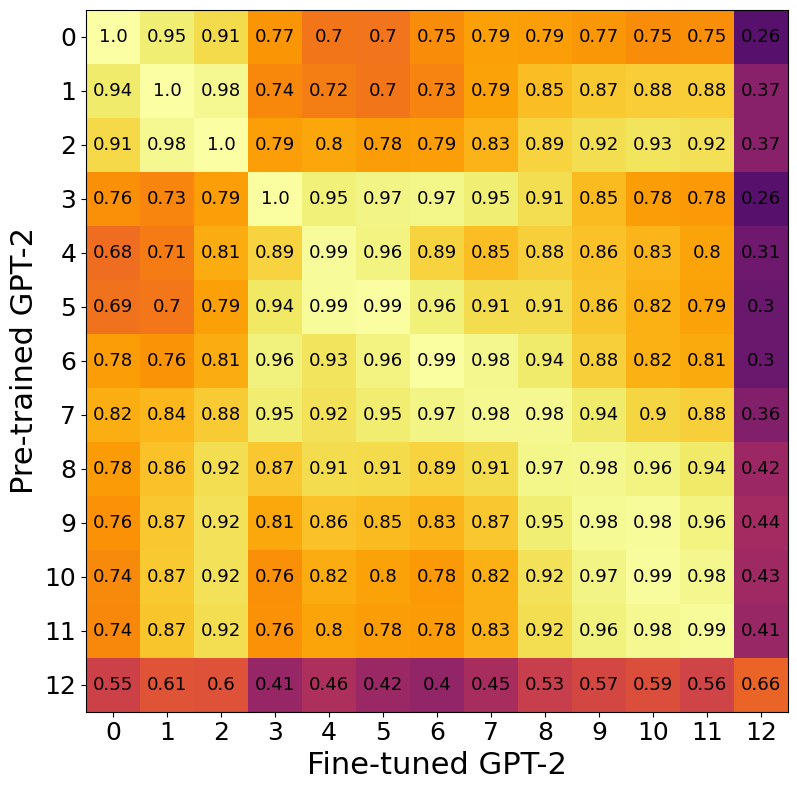

In [14]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 18)
plt.yticks(np.arange(0,13), fontsize = 18)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained GPT-2', fontsize = 22)
plt.xlabel('Fine-tuned GPT-2', fontsize = 22)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('WNLI_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('WNLI_preTrained_fineTuned.jpg',  bbox_inches='tight')

## Calculating layerwise STIR

In [15]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_WNLI.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_WNLI.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 146, 768]) torch.Size([13, 146, 768])


In [16]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [17]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [18]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [19]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [20]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [21]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [22]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [23]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [24]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.9851765  0.9857915  0.9879505  0.99303955 0.9905216  0.993552
 0.99472    0.9925855  0.99145776 0.9888552  0.98933166 0.98686486
 0.8868551 ]
STIRm1m2: [0.98517793 0.98914856 0.98842716 0.99316186 0.9913641  0.9933217
 0.9939092  0.9923586  0.99182034 0.9913134  0.9917781  0.9883938
 0.94640535]
CKA: [1.         0.99936306 0.99909604 0.99605715 0.98801535 0.9941255
 0.9939243  0.9806289  0.9707894  0.98095256 0.9887745  0.98577607
 0.6508375 ]


In [25]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.89]
STIRm1m2:  [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.95]
CKA:  [1.   1.   1.   1.   0.99 0.99 0.99 0.98 0.97 0.98 0.99 0.99 0.65]


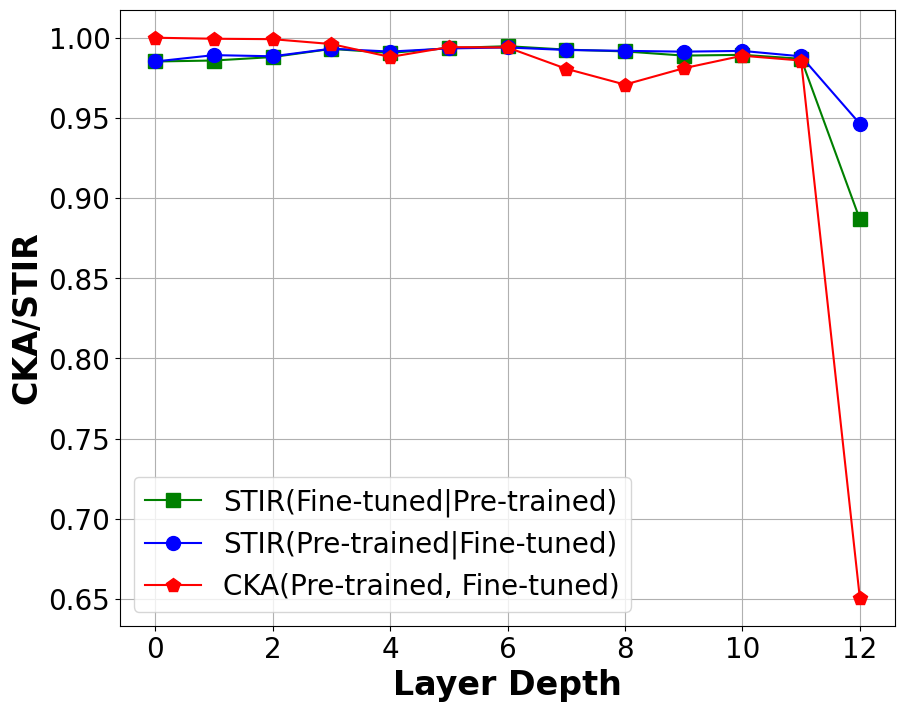

In [26]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=20)
plt.xlabel('Layer Depth', fontsize = 24, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 24, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
#plt.show()
plt.savefig('WNLI CKA STIR.pdf', bbox_inches='tight')
plt.savefig('WNLI CKA STIR.jpg', bbox_inches='tight')

In [9]:
class Dataset(Dataset):
    def __init__(self, sentences1, sentences2):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        
    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, index):
        return {
            'sentence1': self.sentences1[index],
            'sentence2': self.sentences2[index],
            'label':0,
        }


In [10]:
def test(dataloader, device_):
    predictions_labels = []
    model.eval()

    for batch in tqdm(dataloader, total=len(dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        
        with torch.no_grad():        
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
            logits = outputs.logits
            predict_content = torch.argmax(logits, dim = 1).tolist()
            predictions_labels.extend(predict_content)

    return predictions_labels

In [28]:
import pandas as pd
test_dataset = Dataset(test_sentence1, test_sentence2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
predictions = test(test_dataloader, device)
filename = '../bias/WNLI.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]